In [1]:
# dependencies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV


In [2]:
# read csv file into df
df_kd = pd.read_csv("../Resources/telecom_customer_churn.csv")

# Remove rows Where Customer Status = Joined
df_kd = df_kd[df_kd['Customer Status'] != 'Joined']
df_kd.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [3]:
# Data Cleaning:

df_kd['Churn Category'] = df_kd['Churn Category'].replace(np.nan,'satisfied')
df_kd['Internet Type'] = df_kd['Internet Type'].replace(np.nan,'No service')
df_kd['Multiple Lines'] = df_kd['Multiple Lines'].replace(np.nan,'No phone Service')
df_kd['Avg Monthly Long Distance Charges'] = df_kd['Avg Monthly Long Distance Charges'].replace(np.nan,0)
df_kd['Avg Monthly GB Download'] = df_kd['Avg Monthly GB Download'].replace(np.nan,0)
df_kd['Multiple Lines']=df_kd['Multiple Lines'].replace(np.nan,'No service')
df_kd['Internet Service']= df_kd['Internet Service'].replace(np.nan,'No service')
df_kd['Online Security']= df_kd['Online Security'].replace(np.nan,'No service')
df_kd['Online Backup']= df_kd['Online Backup'].replace(np.nan,'No service')
df_kd['Device Protection Plan']= df_kd['Device Protection Plan'].replace(np.nan,'No service')
df_kd['Premium Tech Support']= df_kd['Premium Tech Support'].replace(np.nan,'No service')
df_kd['Streaming TV']= df_kd['Streaming TV'].replace(np.nan,'No service')
df_kd['Streaming Music']= df_kd['Streaming Music'].replace(np.nan,'No service')
df_kd['Unlimited Data']= df_kd['Unlimited Data'].replace(np.nan,'No service')
df_kd['Streaming Movies']= df_kd['Streaming Movies'].replace(np.nan,'No service')

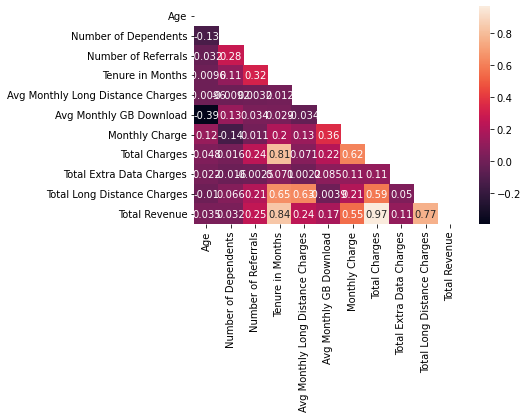

In [4]:
# Feature Selection:
    # isolate x variables for feature selection tests
data_df_kd = df_kd.drop(['Total Refunds', 'Paperless Billing', 'Zip Code', 
    'Latitude', 'Longitude', 'City'],axis=1).set_index('Customer ID')

# Test of multicollinearity of numeric variables
# Isolate numeric variables for correlation analysis:
numeric_types_kd = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_numeric_kd = data_df_kd.select_dtypes(include=numeric_types_kd)

# Create correlation matrix for numeric features
corrmatrix_kd = X_numeric_kd.corr()
# sn.set(rc = {'figure.figsize':(15,8)})
mask_kd = np.triu(np.ones_like(corrmatrix_kd, dtype=bool))
sn.heatmap(corrmatrix_kd, mask=mask_kd, annot=True)
plt.show()

In [5]:
# Function for calculating Variable Inflation Factors on numeric variables
def calculate_vif(X):
    vif_kd = pd.DataFrame()
    vif_kd['variables'] = X.columns
    vif_kd['Variable Inflation Factors'] = [variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])] 
    return vif_kd

In [6]:
# Compare vif before and after highly correlated features are removed
vif_all_num_columns_kd = calculate_vif(X_numeric_kd).sort_values('Variable Inflation Factors', ascending=False)
print(f'First Test (All Numeric Columns):\n {vif_all_num_columns_kd}')

# Remove highly correlated numerical features:
X_num_selection_kd = X_numeric_kd.drop(['Total Long Distance Charges', 'Total Charges', 'Monthly Charge'], axis=1)
vif_selection_kd = calculate_vif(X_num_selection_kd).sort_values('Variable Inflation Factors', ascending=False)
print(f'Second Test (Selected Columns):\n {vif_selection_kd}')

First Test (All Numeric Columns):
                             variables  Variable Inflation Factors
10                      Total Revenue               283071.777638
7                       Total Charges               168131.523910
9         Total Long Distance Charges                20778.931625
6                      Monthly Charge                   14.565743
3                    Tenure in Months                   12.721578
8            Total Extra Data Charges                   11.927896
4   Avg Monthly Long Distance Charges                    8.288615
0                                 Age                    7.391060
5             Avg Monthly GB Download                    2.791548
2                 Number of Referrals                    1.731428
1                Number of Dependents                    1.421003
Second Test (Selected Columns):
                            variables  Variable Inflation Factors
3                   Tenure in Months                   10.771938
7         

In [7]:
# Encode Categorical Data:
def encode_data(df):
    df = LabelEncoder().fit_transform(df)
    return df
categorical_data_kd = data_df_kd.select_dtypes(include='object')
encoded_data_kd = categorical_data_kd.apply(lambda x: encode_data(x))

# Convert y to 1D array
y_kd = np.ravel(encoded_data_kd[['Customer Status']])

# isolate categorical encoded features
features_encoded_kd = encoded_data_kd.drop(['Customer Status', 'Churn Category', 'Churn Reason'], axis=1)

In [8]:
# Classification Feature Selection of the numerical variables against the target (categorical variable)

# ANOVA f-test for feature selection
    # ANOVA: analysis of variance. A test for determining whether the means from two or more samples of data come from the
        # same distribution
    # ANOVA is used when one variable is numeric and one is categorical
    # The methods based on F-test estimate the degree of linear dependency between two random variables
    # The result tells us which features are independent to the target variable

# define feature selection:
    # Select features according to the k highest scores
    # k=5 instructs the variable function to select the (4 best) features that are the most linearly dependent with the target
    # f_classif function computes the ANOVA f-score
fs_num_kd = SelectKBest(score_func=f_classif, k=4)

# apply feature selection:
fs_num_kd.fit(X_num_selection_kd, y_kd)
selected_features_num_kd = fs_num_kd.transform(X_num_selection_kd)

# tabulate features and view dataframe:
numerical_features_df_kd = pd.DataFrame({'numerical_features': X_num_selection_kd.columns, 
    'KBest_to_keep': fs_num_kd.get_support(), 'f-score': fs_num_kd.scores_})
numerical_features_df_kd

# isolate best numerical features
best_num_features_kd = X_numeric_kd[['Number of Dependents', 'Number of Referrals', 'Total Revenue']]
numerical_features_df_kd



,numerical_features,KBest_to_keep,f-score
0,Age,False,82.431541
1,Number of Dependents,True,376.502505
2,Number of Referrals,True,710.948463
3,Tenure in Months,True,1526.535347
4,Avg Monthly Long Distance Charges,False,0.291017
5,Avg Monthly GB Download,False,10.588472
6,Total Extra Data Charges,False,0.000442
7,Total Revenue,True,554.405346


In [9]:
# Classification Feature Selection of the categorical variables against the target (categorical variable)
fs_cat_kd = SelectKBest(score_func=chi2, k=4)

# apply feature selection:
fs_cat_kd.fit(features_encoded_kd, y_kd)
selected_features_num_kd = fs_cat_kd.transform(features_encoded_kd)

# tabulate features and view dataframe:
categorical_features_df_kd = pd.DataFrame({'categorical_features': features_encoded_kd.columns, 
    'KBest_to_keep': fs_cat_kd.get_support(), 'f-score': fs_cat_kd.scores_})
categorical_features_df_kd

# isolate best categorical features
best_cat_features_kd = features_encoded_kd[['Offer', 'Online Security', 'Premium Tech Support', 'Contract']]
categorical_features_df_kd



,categorical_features,KBest_to_keep,f-score
0,Gender,False,0.133089
1,Married,False,109.869893
2,Offer,True,309.680506
3,Phone Service,False,0.132963
4,Multiple Lines,False,0.567943
5,Internet Service,False,67.509142
6,Internet Type,False,6.848586
7,Online Security,True,591.737438
8,Online Backup,False,262.006146
9,Device Protection Plan,False,229.244382


In [10]:
# Collate best features:
merged_X_df_kd = pd.merge(best_num_features_kd, best_cat_features_kd, left_index=True, right_index=True)
X_kd = merged_X_df_kd.reset_index(drop=True)

# Split data into train and test sets:
X_train_kd, X_test_kd, y_train_kd, y_test_kd = train_test_split(X_kd, y_kd, random_state=42, test_size=0.2, stratify=y_kd)

# Normalize the features of our dataset using MinMaxScaler
# fit scaler on training data
X_n_fit_kd = MinMaxScaler().fit(X_train_kd)

# Step 2: Transform the training data
X_n_train_kd = X_n_fit_kd.transform(X_train_kd)

# Step 3: Transform the testing data
X_n_test_kd = X_n_fit_kd.transform(X_test_kd)


In [11]:
###########################################################################
## K Nearest Neighbour Results:
###########################################################################

# Define the model:
knn_model_kd = KNeighborsClassifier()
target_names_kd = ['Stayed', 'Churned']

# summarize results without using gridsarch
knn_model_kd.fit(X_n_train_kd, y_train_kd)
predictions_knn_kd = knn_model_kd.predict(X_n_test_kd)
print('//////////////////////////////////////////////////////////////////')
print("Classification report of knn model without the use of GridSearch:")
print('//////////////////////////////////////////////////////////////////')
print(classification_report(y_test_kd, predictions_knn_kd, target_names=target_names_kd))

# Summarize results with using gridsearch
# (tune) the model with GridSearch and Stratify kfold:
# key parameters:
n_neighbors_kd = range(1, 21, 2)
weights_kd = ['uniform', 'distance']
metric_kd = ['euclidean', 'manhattan', 'minkowski']

# store parameters in parameter object:
param_grid_knn_kd = dict(n_neighbors=n_neighbors_kd, weights=weights_kd, metric=metric_kd)

# Evaluation
cv_knn_kd = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid search estimator:
grid_search_knn_kd = GridSearchCV(estimator=knn_model_kd, param_grid=param_grid_knn_kd, n_jobs=-1, cv=cv_knn_kd, scoring='accuracy', error_score=0)

# fit the grid search using the grid search estimator with the train data:
# This will take the KNN model and try each combination of parameters
grid_search_knn_kd.fit(X_n_train_kd, y_train_kd)
grid_predictions_knn_kd = grid_search_knn_kd.predict(X_n_test_kd)
print('//////////////////////////////////////////////////////////////////')
print('Classification report of knn model with the use of GridSearch:')
print('//////////////////////////////////////////////////////////////////')
print('Test Accuracy: %f, Grid Result: %s' % (grid_search_knn_kd.best_score_, grid_search_knn_kd.best_params_))
print(classification_report(y_test_kd, grid_predictions_knn_kd, target_names=target_names_kd))

//////////////////////////////////////////////////////////////////
Classification report of knn model without the use of GridSearch:
//////////////////////////////////////////////////////////////////
              precision    recall  f1-score   support

      Stayed       0.69      0.68      0.68       374
     Churned       0.87      0.88      0.87       944

    accuracy                           0.82      1318
   macro avg       0.78      0.78      0.78      1318
weighted avg       0.82      0.82      0.82      1318

//////////////////////////////////////////////////////////////////
Classification report of knn model with the use of GridSearch:
//////////////////////////////////////////////////////////////////
Test Accuracy: 0.832605, Grid Result: {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}
              precision    recall  f1-score   support

      Stayed       0.72      0.68      0.70       374
     Churned       0.88      0.90      0.89       944

    accur

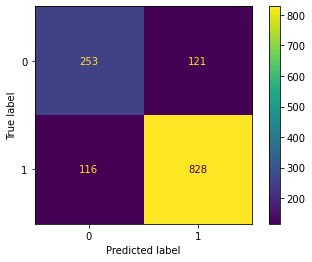

In [12]:
# Plot confusion matrix for knn model without the use of GridSearch:
plot_confusion_matrix(knn_model_kd, X_n_test_kd, y_test_kd, values_format='d')
plt.grid(False)

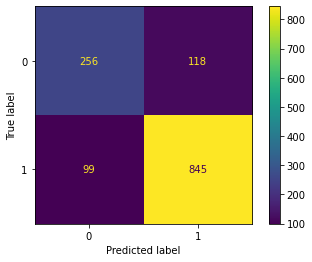

In [13]:
# Plot confusion matrix for knn model with the use of GridSearch:
plot_confusion_matrix(grid_search_knn_kd, X_n_test_kd, y_test_kd, values_format='d')
plt.grid(False)

In [14]:
###########################################################################
## Logistic Regression Results:
###########################################################################

# Define the model:
logistic_model_kd = LogisticRegression()


# summarize results without using gridsarch
logistic_model_kd.fit(X_n_train_kd, y_train_kd)
predictions_lm_kd = logistic_model_kd.predict(X_n_test_kd)
print('//////////////////////////////////////////////////////////////////')
print("Classification report of logistic model without the use of GridSearch:")
print('//////////////////////////////////////////////////////////////////')
print(classification_report(y_test_kd, predictions_lm_kd, target_names=target_names_kd))

# Summarize results with using gridsearch
# (tune) the model with GridSearch and Stratify kfold:
# key parameters:
solver_kd = ['newton-cg', 'lbfgs', 'liblinear']
penalty_kd = ['none', 'l1', 'l2', 'elasticnet']
C_kd = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# store parameters in parameter object:
param_grid_lm_kd = dict(solver=solver_kd, penalty=penalty_kd, C=C_kd)

# Evaluation:
cv_lm_kd = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid search estimator:
grid_search_lm_kd = GridSearchCV(estimator=logistic_model_kd, param_grid=param_grid_lm_kd, n_jobs=-1, cv=cv_lm_kd, scoring='accuracy', error_score=0)

# fit the grid search using the grid search estimator with the train data:
# This will take the KNN model and try each combination of parameters
grid_search_lm_kd.fit(X_n_train_kd, y_train_kd)
grid_predictions_lm_kd = grid_search_lm_kd.predict(X_n_test_kd)
print('//////////////////////////////////////////////////////////////////')
print('Classification report of logistic model with the use of GridSearch:')
print('//////////////////////////////////////////////////////////////////')
print('Test Accuracy: %f, Grid Result: %s' % (grid_search_lm_kd.best_score_, grid_search_lm_kd.best_params_))
print(classification_report(y_test_kd, grid_predictions_lm_kd, target_names=target_names_kd))


//////////////////////////////////////////////////////////////////
Classification report of logistic model without the use of GridSearch:
//////////////////////////////////////////////////////////////////
              precision    recall  f1-score   support

      Stayed       0.65      0.69      0.67       374
     Churned       0.88      0.85      0.86       944

    accuracy                           0.81      1318
   macro avg       0.76      0.77      0.77      1318
weighted avg       0.81      0.81      0.81      1318

//////////////////////////////////////////////////////////////////
Classification report of logistic model with the use of GridSearch:
//////////////////////////////////////////////////////////////////
Test Accuracy: 0.822738, Grid Result: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

      Stayed       0.71      0.62      0.66       374
     Churned       0.86      0.90      0.88       944

    accuracy 

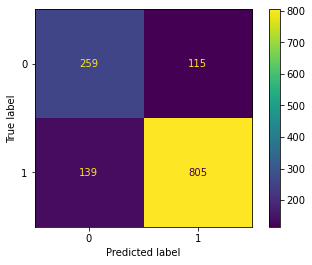

In [15]:
# Plot confusion matrix for logistic model without the use of GridSearch:
plot_confusion_matrix(logistic_model_kd, X_n_test_kd, y_test_kd, values_format='d')
plt.grid(False)

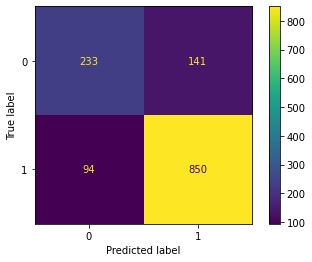

In [16]:
# Plot confusion matrix for logistic model with the use of GridSearch:
plot_confusion_matrix(grid_search_lm_kd, X_n_test_kd, y_test_kd, values_format='d')
plt.grid(False)